In [1]:
import numpy as np
import nmp_util
import sympy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

In [2]:
data = pd.read_csv('data/serie4-observationsobs.sec', delimiter = r'\s+', names = ['I', 'z' , 's_z'], skiprows = [0])
display(data)

,I,z,s_z
1,0.05,27.0,3.6
2,0.10,59.0,5.4
3,0.15,146.0,8.5
4,0.17,183.0,7.8
5,0.20,228.0,10.7
6,0.22,228.0,10.7
7,0.25,268.0,9.5
8,0.27,268.5,8.8
9,0.30,277.0,11.8
10,0.32,283.5,11.9


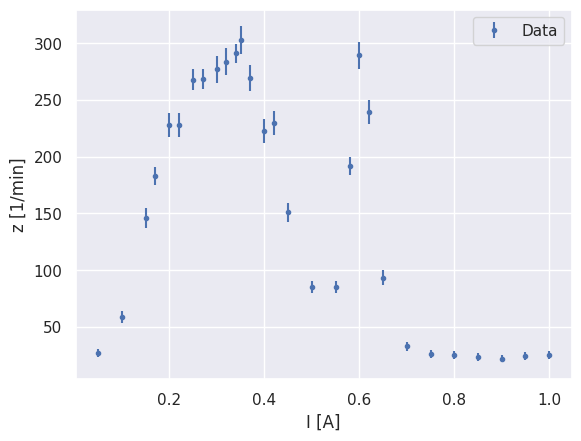

In [3]:
sns.set_theme()
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.errorbar(data['I'], data['z'], data['s_z'], fmt='.', label = 'Data')
plt.legend()
plt.show()

# Define the functional model with sympy

In [4]:
a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I = sympy.symbols('a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2, I')

with sympy.evaluate(False):
    sqrt2pi = sympy.sqrt(2*sympy.pi)
    f_expr = \
        a_1 / (sqrt2pi * sigma_1) * sympy.exp(-(I-mu_1)**2 / (2 * sigma_1**2)) +\
        a_2 / (sqrt2pi * sigma_2) * sympy.exp(-(I-mu_2)**2 / (2 * sigma_2**2)) + a_0

parameter_symbols = [a_0, a_1, a_2, sigma_1, sigma_2, mu_1, mu_2]

display(f_expr)
print(sympy.latex(f_expr))

a_0 + ((a_1/((sigma_1*sqrt(2*pi))))*exp((-(I - mu_1)**2)/((2*sigma_1**2))) + (a_2/((sigma_2*sqrt(2*pi))))*exp((-(I - mu_2)**2)/((2*sigma_2**2))))

a_{0} + \left(\frac{a_{1}}{\sigma_{1} \sqrt{2 \pi}} e^{\frac{\left(-1\right) \left(I - \mu_{1}\right)^{2}}{2 \sigma_{1}^{2}}} + \frac{a_{2}}{\sigma_{2} \sqrt{2 \pi}} e^{\frac{\left(-1\right) \left(I - \mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}}\right)


In [13]:
f = nmp_util.SympyFunctionalModel(f_expr, parameter_symbols, I)

models : list[nmp_util.SympyFunctionalModel] = []

def log(model : nmp_util.SympyFunctionalModel):
    print(f'Itaration:{model.iterations:2d}, m_0: {model.m_0:.10f}')
    # store these for a later exercise
    models.append(model.copy())

f.logger = log

for p in f.differential_expressions:
    display(p)
    print(sympy.latex(p))

1

1


(sqrt(2)/(2*sqrt(pi)*sigma_1))*exp((-(I - mu_1)**2)/((2*sigma_1**2)))

\frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{1}} e^{\frac{\left(-1\right) \left(I - \mu_{1}\right)^{2}}{2 \sigma_{1}^{2}}}


(sqrt(2)/(2*sqrt(pi)*sigma_2))*exp((-(I - mu_2)**2)/((2*sigma_2**2)))

\frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{2}} e^{\frac{\left(-1\right) \left(I - \mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}}


-sqrt(2)*a_1*exp((-(I - mu_1)**2)/((2*sigma_1**2)))/(2*sqrt(pi)*sigma_1**2) + a_1*(sqrt(2)/(2*sqrt(pi)*sigma_1))*(I - mu_1)**2*exp((-(I - mu_1)**2)/((2*sigma_1**2)))/sigma_1**3

- \frac{\sqrt{2} a_{1} e^{\frac{\left(-1\right) \left(I - \mu_{1}\right)^{2}}{2 \sigma_{1}^{2}}}}{2 \sqrt{\pi} \sigma_{1}^{2}} + \frac{a_{1} \frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{1}} \left(I - \mu_{1}\right)^{2} e^{\frac{\left(-1\right) \left(I - \mu_{1}\right)^{2}}{2 \sigma_{1}^{2}}}}{\sigma_{1}^{3}}


-sqrt(2)*a_2*exp((-(I - mu_2)**2)/((2*sigma_2**2)))/(2*sqrt(pi)*sigma_2**2) + a_2*(sqrt(2)/(2*sqrt(pi)*sigma_2))*(I - mu_2)**2*exp((-(I - mu_2)**2)/((2*sigma_2**2)))/sigma_2**3

- \frac{\sqrt{2} a_{2} e^{\frac{\left(-1\right) \left(I - \mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}}}{2 \sqrt{\pi} \sigma_{2}^{2}} + \frac{a_{2} \frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{2}} \left(I - \mu_{2}\right)^{2} e^{\frac{\left(-1\right) \left(I - \mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}}}{\sigma_{2}^{3}}


a_1*(sqrt(2)/(2*sqrt(pi)*sigma_1))*(2*I - 2*mu_1)*exp((-(I - mu_1)**2)/((2*sigma_1**2)))/(2*sigma_1**2)

\frac{a_{1} \frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{1}} \left(2 I - 2 \mu_{1}\right) e^{\frac{\left(-1\right) \left(I - \mu_{1}\right)^{2}}{2 \sigma_{1}^{2}}}}{2 \sigma_{1}^{2}}


a_2*(sqrt(2)/(2*sqrt(pi)*sigma_2))*(2*I - 2*mu_2)*exp((-(I - mu_2)**2)/((2*sigma_2**2)))/(2*sigma_2**2)

\frac{a_{2} \frac{\sqrt{2}}{2 \sqrt{\pi} \sigma_{2}} \left(2 I - 2 \mu_{2}\right) e^{\frac{\left(-1\right) \left(I - \mu_{2}\right)^{2}}{2 \sigma_{2}^{2}}}}{2 \sigma_{2}^{2}}


In [14]:
sigma_0 = 1

cofactor_matrix = np.diag(data['s_z'].to_numpy()**2) / sigma_0**2
weight_matrix = sparse.dia_matrix(np.linalg.inv(cofactor_matrix))
# the default values are given in the exercise, except for a_0, simply chose 0 for a_0 and see if this converges
f.parameters = np.array([0, 50, 50, 0.05, 0.05, 0.3, 0.6])

f.fit(data['I'], data['z'], weight_matrix)

Itaration: 1, m_0: 5.1459459481
Itaration: 2, m_0: 2.4214154452
Itaration: 3, m_0: 1.9989849978
Itaration: 4, m_0: 1.9873981444
Itaration: 5, m_0: 1.9870631055
Itaration: 6, m_0: 1.9870506615
Itaration: 7, m_0: 1.9870502009
Itaration: 8, m_0: 1.9870501838
Itaration: 9, m_0: 1.9870501832
Itaration:10, m_0: 1.9870501832


In [15]:
print(f'chi statistic for alpha = 5%')
print(f.m_0 / sigma_0)
print(f.dof)
print(f'functional model : {f.m_0**2 / sigma_0**2}')
print(f'critical value : {f.chi2_threshold(0.05)}')

chi statistic for alpha = 5%
1.9870501831782679
22
functional model : 3.948368430468788
critical value : 1.542019930520173


parameters:
$a_{0} = \SI{23.255(2.626)}$
$a_{1} = \SI{79.125(2.732)}$
$a_{2} = \SI{16.997(1.090)}$
$\sigma_{1} = \SI{0.113(0.004)}$
$\sigma_{2} = \SI{0.027(0.002)}$
$\mu_{1} = \SI{0.309(0.004)}$
$\mu_{2} = \SI{0.606(0.002)}$
parameter correlation matrix


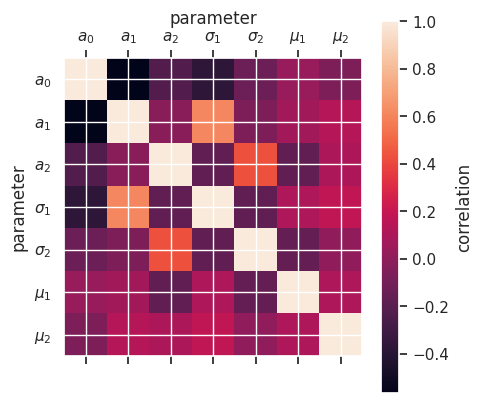

In [16]:
print(f'parameters:')
f.print_parameters_latex()
print(f'parameter correlation matrix')
f.show_correlation()
plt.show()

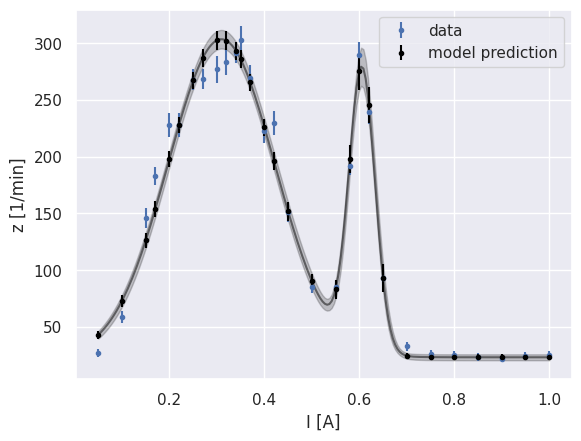

In [9]:
f.plot()
plt.xlabel('I [A]')
plt.ylabel('z [1/min]')
plt.show()

In [10]:
def evaluate(I_val):
    z = f.eval(I_val)
    z_err = f.eval_stderr(I_val, sigma = f.m_0)[0]
    print(f'I = {I_val:.3f}')
    print(f'z = {z:.3f} +- {z_err:.3f}')

evaluate(data['I'].iloc[0])
print()
evaluate(0.12)
print()

factor_expr = a_1 / (sqrt2pi * sigma_1)

print(sympy.latex(factor_expr))

factor, factor_cov = nmp_util.propagate_error(factor_expr, parameter_symbols, f.parameters, f.m_0**2 * f.parameter_cof())
factor_err = factor_cov[0,0]**0.5
print(f'factor = {factor:.3f} +- {factor_err:.3f}')

I = 0.050
z = 43.025 +- 3.370

I = 0.120
z = 91.456 +- 6.037

\frac{\sqrt{2} a_{1}}{2 \sqrt{\pi} \sigma_{1}}
factor = 280.302 +- 8.402


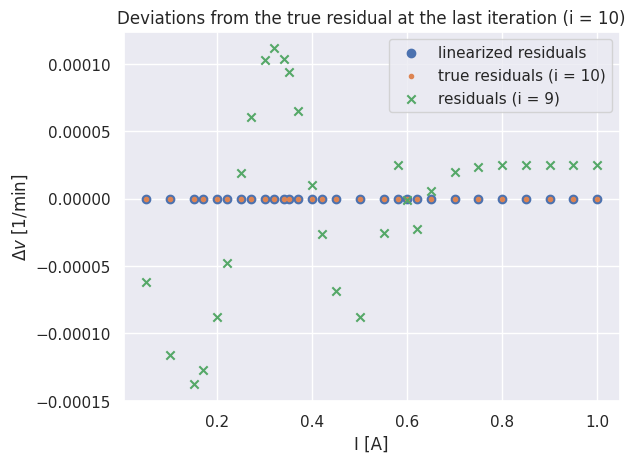

In [11]:
true_residuals = f.residuals
linearized_residuals = f.A @ f.parameters - f.y
i = 8

other_model = models[i]

# this checks if the design matrix is a good taylor approximation
linearized_residuals = other_model.residuals - other_model.A @ (f.parameters - other_model.parameters)

# i+1 because we the first iteration is 1, but the arrays are 0-indexed
plt.title('Deviations from the true residual at the last iteration (i = 10)')
plt.scatter(f.x, true_residuals-linearized_residuals, marker='o', label = f'linearized residuals')
plt.scatter(f.x, true_residuals-true_residuals,marker = '.', label = f'true residuals (i = {len(models)})')
plt.scatter(f.x, true_residuals-other_model.residuals,marker ='x', label = f'residuals (i = {i+1})')
plt.xlabel('I [A]')
plt.ylabel('$\\Delta v$ [1/min]')
plt.legend()
plt.show()

0.9905262690304637
no outliers detected: True


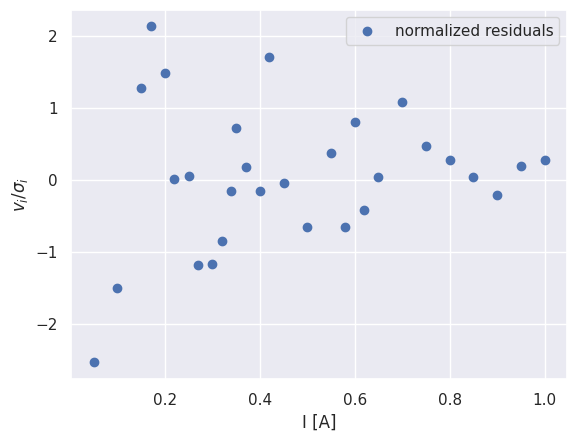

In [12]:
residual_covariance = f.m_0**2 * (cofactor_matrix - f.eval_cof(f.x))

normalized_residuals = f.residuals / np.diag(residual_covariance)**0.5
plt.scatter(data['I'], normalized_residuals, label = 'normalized residuals')

plt.xlabel('I [A]')
plt.ylabel('$v_i / \\sigma_i$')
plt.legend()
print(normalized_residuals.std(ddof=1))

print(f'no outliers detected: {nmp_util.get_inliers(normalized_residuals).all()}')